In [1]:
import torch
import sklearn

In [2]:
# import kagglehub
# path = kagglehub.dataset_download("zalando-research/fashionmnist")
# print("Path to dataset files:", path)

In [3]:
import pandas as pd
df = pd.read_csv('./Data/fashion-mnist_train.csv')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [5]:
df.shape

(60000, 785)

In [6]:
import matplotlib.pyplot as plt

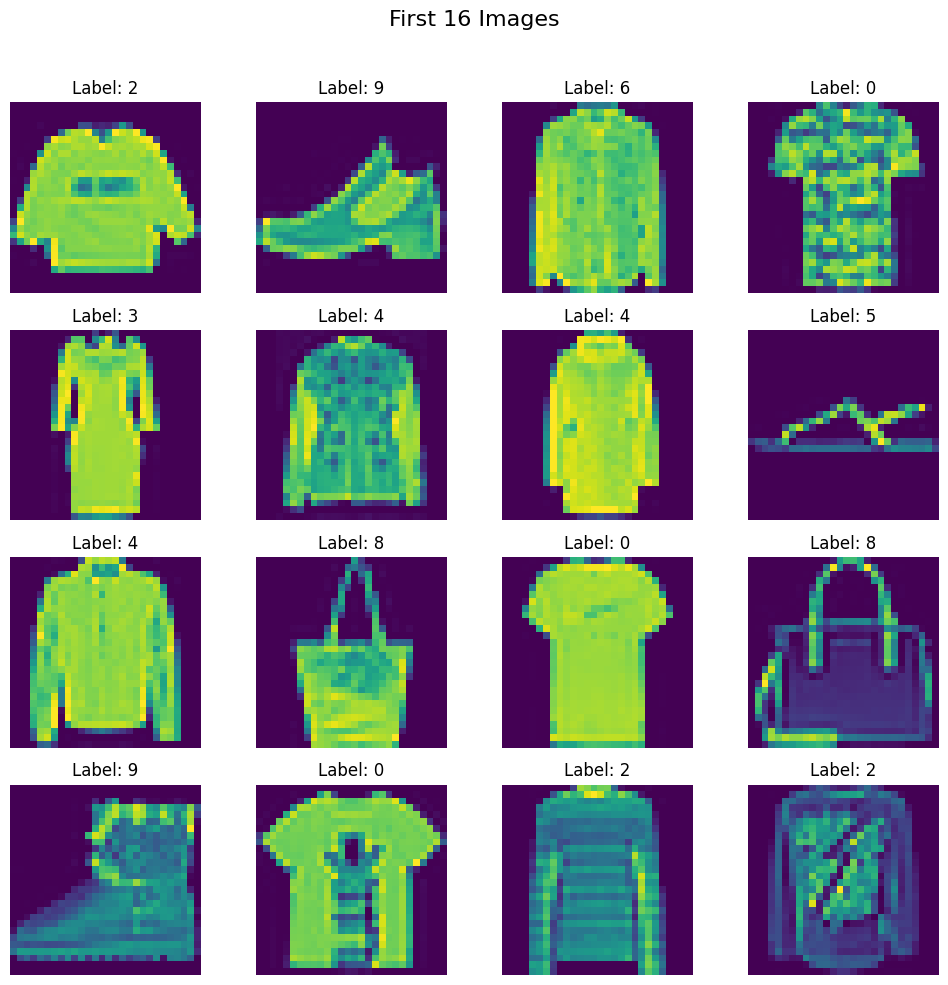

In [7]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [8]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [10]:
X_train= X_train/255.0
X_test= X_test/255.0    

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [13]:
import torch.nn as nn

In [14]:
# class MyNN(nn.Module):
    
#   def __init__(self, num_features):

#     super().__init__()
#     self.model = nn.Sequential(
#         nn.Linear(num_features, 128),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.Dropout(p=0.2),
#         nn.Linear(128, 64),
#         nn.BatchNorm1d(64),
#         nn.ReLU(),
#         nn.Dropout(p=0.2),
#         nn.Linear(64, 10)

#     )

#   def forward(self, x):

#     return self.model(x)

In [15]:
class MyNN(nn.Module):
    def __init__(self, num_hidden_layers, neurons_per_layers, input_dim, output_dim,dropout_rate):
        super().__init__()
        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim if i == 0 else neurons_per_layers, neurons_per_layers))
            layers.append(nn.BatchNorm1d(neurons_per_layers))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(neurons_per_layers, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [16]:
def objective_function(trial):
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    neurons_per_layers = trial.suggest_int('neurons_per_layers', 8, 128 , step=8)
    epochs = trial.suggest_int('epochs', 50, 200, step=10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
    
    input_dim = 784
    output_dim = 10
    model = MyNN(num_hidden_layers, neurons_per_layers, input_dim, output_dim, dropout_rate)
    model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    
    # training loop
    
    for epoch in range(epochs):
    
      total_epoch_loss = 0
    
      for batch_features, batch_labels in train_loader:
    
        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    
        # forward pass
        outputs = model(batch_features)
    
        # calculate loss
        loss = criterion(outputs, batch_labels)
    
        # back pass
        optimizer.zero_grad()
        loss.backward()
    
        # update grads
        optimizer.step()
    
        total_epoch_loss = total_epoch_loss + loss.item()
    
      avg_loss = total_epoch_loss/len(train_loader)
      print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')
      
    model.eval()
    # evaluation code
    total = 0
    correct = 0

    with torch.no_grad():

      for batch_features, batch_labels in train_loader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total
    return accuracy

In [17]:
import optuna

study = optuna.create_study(direction='maximize')


c:\Users\yuvra\anaconda3\envs\tf-working\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-05 11:56:46,407] A new study created in memory with name: no-name-fadffd33-8660-469d-a4f0-798925f456e5


In [ ]:
study.optimize(objective_function, n_trials=10)

Epoch: 1 , Loss: 1.1385531822045645
Epoch: 2 , Loss: 1.213872179031372
Epoch: 3 , Loss: 1.2696848840713502
Epoch: 4 , Loss: 1.2952220074335734
Epoch: 5 , Loss: 1.32382474843661
Epoch: 6 , Loss: 1.3686689834594727
Epoch: 7 , Loss: 1.351723121881485
Epoch: 8 , Loss: 1.3727295060157776
Epoch: 9 , Loss: 1.4050825874010722
Epoch: 10 , Loss: 1.404184405485789
Epoch: 11 , Loss: 1.4296553346316019
Epoch: 12 , Loss: 1.4408589045206706
Epoch: 13 , Loss: 1.4315163474082946
Epoch: 14 , Loss: 1.434534277757009
Epoch: 15 , Loss: 1.444132493019104
Epoch: 16 , Loss: 1.439219761689504
Epoch: 17 , Loss: 1.4272822141647339
Epoch: 18 , Loss: 1.4363844354947408
Epoch: 19 , Loss: 1.4369180274009705
Epoch: 20 , Loss: 1.4451386167208353
Epoch: 21 , Loss: 1.4536133534113567
Epoch: 22 , Loss: 1.4333609210650127
Epoch: 23 , Loss: 1.432980537891388
Epoch: 24 , Loss: 1.4538794860839843
Epoch: 25 , Loss: 1.4378427685101827
Epoch: 26 , Loss: 1.428328239440918
Epoch: 27 , Loss: 1.4023569588661193
Epoch: 28 , Loss: 1.

[I 2025-09-05 12:05:30,274] Trial 0 finished with value: 0.4872916666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 112, 'epochs': 150, 'learning_rate': 0.07069537931217401, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 0.0009559079791787491}. Best is trial 0 with value: 0.4872916666666667.


Epoch: 1 , Loss: 0.573200603167216
Epoch: 2 , Loss: 0.4406909058491389
Epoch: 3 , Loss: 0.40187355784575146
Epoch: 4 , Loss: 0.3780837255716324
Epoch: 5 , Loss: 0.3664483822584152
Epoch: 6 , Loss: 0.35510366733868914
Epoch: 7 , Loss: 0.34448188384373984
Epoch: 8 , Loss: 0.335629622220993
Epoch: 9 , Loss: 0.3311969301700592
Epoch: 10 , Loss: 0.3306178923050562
Epoch: 11 , Loss: 0.3273043246269226
Epoch: 12 , Loss: 0.32354253228505453
Epoch: 13 , Loss: 0.3174067405660947
Epoch: 14 , Loss: 0.314917409380277
Epoch: 15 , Loss: 0.31365240959326424
Epoch: 16 , Loss: 0.3117739579677582
Epoch: 17 , Loss: 0.3102847830454509
Epoch: 18 , Loss: 0.311081747174263
Epoch: 19 , Loss: 0.30310228220621743
Epoch: 20 , Loss: 0.3041853200594584
Epoch: 21 , Loss: 0.3057468354701996
Epoch: 22 , Loss: 0.29971300188700356
Epoch: 23 , Loss: 0.2965271405776342
Epoch: 24 , Loss: 0.29765377823511757
Epoch: 25 , Loss: 0.2986980321407318
Epoch: 26 , Loss: 0.3022162166039149
Epoch: 27 , Loss: 0.2937099814414978
Epoch:

[I 2025-09-05 12:08:38,320] Trial 1 finished with value: 0.9144166666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 120, 'epochs': 100, 'learning_rate': 0.052090504280611065, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 0.00043001188907704116}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.7555064873695374
Epoch: 2 , Loss: 0.7244421132405598
Epoch: 3 , Loss: 0.7193651757240296
Epoch: 4 , Loss: 0.7268488643964132
Epoch: 5 , Loss: 0.7243643750349681
Epoch: 6 , Loss: 0.7193567589124044
Epoch: 7 , Loss: 0.7165005917549133
Epoch: 8 , Loss: 0.7205614954630534
Epoch: 9 , Loss: 0.7236377696990967
Epoch: 10 , Loss: 0.7221877827644348
Epoch: 11 , Loss: 0.7165575995445251
Epoch: 12 , Loss: 0.7238447155952453
Epoch: 13 , Loss: 0.7243181420962016
Epoch: 14 , Loss: 0.7168959051767985
Epoch: 15 , Loss: 0.7218695689837138
Epoch: 16 , Loss: 0.7163245986302693
Epoch: 17 , Loss: 0.7219102835655212
Epoch: 18 , Loss: 0.7236593867937724
Epoch: 19 , Loss: 0.7180537853240967
Epoch: 20 , Loss: 0.7261789208253224
Epoch: 21 , Loss: 0.7257059845924377
Epoch: 22 , Loss: 0.7256772290865581
Epoch: 23 , Loss: 0.7196793637275696
Epoch: 24 , Loss: 0.7218409775098165
Epoch: 25 , Loss: 0.7251489680608113
Epoch: 26 , Loss: 0.7210312102635702
Epoch: 27 , Loss: 0.7221967345873515
Epoch: 28 

[I 2025-09-05 12:13:02,729] Trial 2 finished with value: 0.7373125 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 88, 'epochs': 190, 'learning_rate': 0.001075730680988741, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.00880107872388559}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.8016730301380157
Epoch: 2 , Loss: 0.7529459043343862
Epoch: 3 , Loss: 0.7522462867101034
Epoch: 4 , Loss: 0.7499050210316975
Epoch: 5 , Loss: 0.7635075623194376
Epoch: 6 , Loss: 0.76067005499204
Epoch: 7 , Loss: 0.755915603796641
Epoch: 8 , Loss: 0.7487299615542093
Epoch: 9 , Loss: 0.7572315907478333
Epoch: 10 , Loss: 0.7510612840652466
Epoch: 11 , Loss: 0.756931660970052
Epoch: 12 , Loss: 0.7549104126294454
Epoch: 13 , Loss: 0.7503408144315084
Epoch: 14 , Loss: 0.7512080561319987
Epoch: 15 , Loss: 0.7472722484270732
Epoch: 16 , Loss: 0.7435236207644145
Epoch: 17 , Loss: 0.7522248622576395
Epoch: 18 , Loss: 0.7585244959195455
Epoch: 19 , Loss: 0.759592402935028
Epoch: 20 , Loss: 0.7541979584693909
Epoch: 21 , Loss: 0.7565749578475952
Epoch: 22 , Loss: 0.7577781879107157
Epoch: 23 , Loss: 0.7580389324824015
Epoch: 24 , Loss: 0.757653635819753
Epoch: 25 , Loss: 0.7571226647694905
Epoch: 26 , Loss: 0.7555848271052042
Epoch: 27 , Loss: 0.7623057673772176
Epoch: 28 , Loss

[I 2025-09-05 12:16:08,258] Trial 3 finished with value: 0.7379583333333334 and parameters: {'num_hidden_layers': 2, 'neurons_per_layers': 72, 'epochs': 110, 'learning_rate': 0.0023603052501903403, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.002219593939356872}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.6933891640901566
Epoch: 2 , Loss: 0.5481232748230298
Epoch: 3 , Loss: 0.5079166116515795
Epoch: 4 , Loss: 0.4915651689370473
Epoch: 5 , Loss: 0.4784819678664207
Epoch: 6 , Loss: 0.46915441248814266
Epoch: 7 , Loss: 0.4646245902578036
Epoch: 8 , Loss: 0.4590796359380086
Epoch: 9 , Loss: 0.45334796422719953
Epoch: 10 , Loss: 0.45043978313604993
Epoch: 11 , Loss: 0.4430623274842898
Epoch: 12 , Loss: 0.4496989871263504
Epoch: 13 , Loss: 0.43715018731355665
Epoch: 14 , Loss: 0.4419283488194148
Epoch: 15 , Loss: 0.4388500981330872
Epoch: 16 , Loss: 0.43115248372157416
Epoch: 17 , Loss: 0.4344526254137357
Epoch: 18 , Loss: 0.4350676417350769
Epoch: 19 , Loss: 0.4305905884106954
Epoch: 20 , Loss: 0.43626421882708866
Epoch: 21 , Loss: 0.4279086863398552
Epoch: 22 , Loss: 0.42788109761476517
Epoch: 23 , Loss: 0.4299471501708031
Epoch: 24 , Loss: 0.43128115169207254
Epoch: 25 , Loss: 0.4263385015130043
Epoch: 26 , Loss: 0.42937698076168695
Epoch: 27 , Loss: 0.42652466772
Epoch:

[I 2025-09-05 12:24:36,545] Trial 4 finished with value: 0.8925 and parameters: {'num_hidden_layers': 2, 'neurons_per_layers': 72, 'epochs': 200, 'learning_rate': 0.026865253174133977, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 0.00041456718482872396}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.9604221054712931
Epoch: 2 , Loss: 0.7438124557634195
Epoch: 3 , Loss: 0.6886933228100339
Epoch: 4 , Loss: 0.6546988224188487
Epoch: 5 , Loss: 0.6297988381783167
Epoch: 6 , Loss: 0.6152167063529292
Epoch: 7 , Loss: 0.6080269472946723
Epoch: 8 , Loss: 0.5886966190064947
Epoch: 9 , Loss: 0.5754916435579459
Epoch: 10 , Loss: 0.5667967443043987
Epoch: 11 , Loss: 0.5626004355972012
Epoch: 12 , Loss: 0.5614937183707952
Epoch: 13 , Loss: 0.5481233418981234
Epoch: 14 , Loss: 0.5462389131387074
Epoch: 15 , Loss: 0.5361142054498196
Epoch: 16 , Loss: 0.5350608733246723
Epoch: 17 , Loss: 0.5320875159353018
Epoch: 18 , Loss: 0.5278866288078328
Epoch: 19 , Loss: 0.5170891975586613
Epoch: 20 , Loss: 0.5199969867691397
Epoch: 21 , Loss: 0.5197768932605783
Epoch: 22 , Loss: 0.5144347293749452
Epoch: 23 , Loss: 0.5124178185760975
Epoch: 24 , Loss: 0.5121189886356393
Epoch: 25 , Loss: 0.5070343558986982
Epoch: 26 , Loss: 0.5072345939601461
Epoch: 27 , Loss: 0.501252103532354
Epoch: 28 ,

[I 2025-09-05 13:12:30,293] Trial 5 finished with value: 0.9069791666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 112, 'epochs': 80, 'learning_rate': 0.0025480920256700365, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.00010878860302762834}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.9240426726341248
Epoch: 2 , Loss: 0.7985984221299489
Epoch: 3 , Loss: 0.7887900873819987
Epoch: 4 , Loss: 0.7843066737651825
Epoch: 5 , Loss: 0.7765631829897562
Epoch: 6 , Loss: 0.7777571489016215
Epoch: 7 , Loss: 0.7846340304613113
Epoch: 8 , Loss: 0.7744518799781799
Epoch: 9 , Loss: 0.7811593102614085
Epoch: 10 , Loss: 0.7718372816642125
Epoch: 11 , Loss: 0.7745069084167481
Epoch: 12 , Loss: 0.776791390299797
Epoch: 13 , Loss: 0.7710021796226502
Epoch: 14 , Loss: 0.7751852707862854
Epoch: 15 , Loss: 0.7775392165581385
Epoch: 16 , Loss: 0.7678117847839991
Epoch: 17 , Loss: 0.7682607874075572
Epoch: 18 , Loss: 0.7796550347010295
Epoch: 19 , Loss: 0.7762496702273687
Epoch: 20 , Loss: 0.7760202652613322
Epoch: 21 , Loss: 0.7833683140675227
Epoch: 22 , Loss: 0.775309322754542
Epoch: 23 , Loss: 0.7760576310952505
Epoch: 24 , Loss: 0.7595655097961426
Epoch: 25 , Loss: 0.7753384834130606
Epoch: 26 , Loss: 0.7711879186232885
Epoch: 27 , Loss: 0.7718199294805527
Epoch: 28 , 

[I 2025-09-05 13:18:08,619] Trial 6 finished with value: 0.8154791666666666 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 32, 'epochs': 110, 'learning_rate': 0.0045191053555173315, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 0.003694545137075133}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 1.0515806766152382
Epoch: 2 , Loss: 0.9316543149550756
Epoch: 3 , Loss: 0.915852520386378
Epoch: 4 , Loss: 0.9078977241913477
Epoch: 5 , Loss: 0.9153864792585373
Epoch: 6 , Loss: 0.9047752910256386
Epoch: 7 , Loss: 0.9197973856925964
Epoch: 8 , Loss: 0.9125072068770727
Epoch: 9 , Loss: 0.911383305768172
Epoch: 10 , Loss: 0.9108958070874215
Epoch: 11 , Loss: 0.9163471615115801
Epoch: 12 , Loss: 0.9061008359789848
Epoch: 13 , Loss: 0.914823477824529
Epoch: 14 , Loss: 0.9192546106179555
Epoch: 15 , Loss: 0.9148303627769152
Epoch: 16 , Loss: 0.9176631772915522
Epoch: 17 , Loss: 0.9177983599901199
Epoch: 18 , Loss: 0.9111409983634948
Epoch: 19 , Loss: 0.9049382909138998
Epoch: 20 , Loss: 0.915780848244826
Epoch: 21 , Loss: 0.9202361911535263
Epoch: 22 , Loss: 0.9142189406752587
Epoch: 23 , Loss: 0.9161937220891316
Epoch: 24 , Loss: 0.9164375502069791
Epoch: 25 , Loss: 0.9230625176827113
Epoch: 26 , Loss: 0.9177373560070992
Epoch: 27 , Loss: 0.9156089849273363
Epoch: 28 , Lo

[I 2025-09-05 13:35:53,549] Trial 7 finished with value: 0.7750208333333334 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 72, 'epochs': 200, 'learning_rate': 0.08785894790103646, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 0.0009464651962152193}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.5300732137362162
Epoch: 2 , Loss: 0.408453316728274
Epoch: 3 , Loss: 0.3751636032660802
Epoch: 4 , Loss: 0.3624820942481359
Epoch: 5 , Loss: 0.3459312032858531
Epoch: 6 , Loss: 0.3384274818897247
Epoch: 7 , Loss: 0.33240725481510164
Epoch: 8 , Loss: 0.32725717798868814
Epoch: 9 , Loss: 0.3220018574396769
Epoch: 10 , Loss: 0.3193478415409724
Epoch: 11 , Loss: 0.3131061179637909
Epoch: 12 , Loss: 0.3119818643728892
Epoch: 13 , Loss: 0.310298887014389
Epoch: 14 , Loss: 0.3044570759534836
Epoch: 15 , Loss: 0.30569213700294495
Epoch: 16 , Loss: 0.29963361370563507
Epoch: 17 , Loss: 0.30190209348996483
Epoch: 18 , Loss: 0.2985738494793574
Epoch: 19 , Loss: 0.2985235767563184
Epoch: 20 , Loss: 0.2984284321864446
Epoch: 21 , Loss: 0.2920484302441279
Epoch: 22 , Loss: 0.2958065222899119
Epoch: 23 , Loss: 0.2945422082742055
Epoch: 24 , Loss: 0.2891316934029261
Epoch: 25 , Loss: 0.28852711204687753
Epoch: 26 , Loss: 0.28655017840862274
Epoch: 27 , Loss: 0.28949287144343056
Epoc

[I 2025-09-05 13:39:10,595] Trial 8 finished with value: 0.9003541666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 88, 'epochs': 160, 'learning_rate': 0.003047388681810368, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.00017803305028068578}. Best is trial 1 with value: 0.9144166666666667.


Epoch: 1 , Loss: 0.8289013297657172
Epoch: 2 , Loss: 0.735699787174662
Epoch: 3 , Loss: 0.7328560192833344
Epoch: 4 , Loss: 0.7283362889736891
Epoch: 5 , Loss: 0.7263963948438565
Epoch: 6 , Loss: 0.7241648498177529
Epoch: 7 , Loss: 0.7210682554294666
Epoch: 8 , Loss: 0.7265078511138757
Epoch: 9 , Loss: 0.7179929731016358
Epoch: 10 , Loss: 0.7168009482522806
Epoch: 11 , Loss: 0.7208198583076397
Epoch: 12 , Loss: 0.7188954454362393
Epoch: 13 , Loss: 0.7174051552514236
Epoch: 14 , Loss: 0.7196194975475471
Epoch: 15 , Loss: 0.7164938885321219
Epoch: 16 , Loss: 0.7192648783375819
Epoch: 17 , Loss: 0.7173919825007519
Epoch: 18 , Loss: 0.7214787011742592
Epoch: 19 , Loss: 0.7118490026344856
Epoch: 20 , Loss: 0.7202279855410259
Epoch: 21 , Loss: 0.7166170920431614
Epoch: 22 , Loss: 0.7271998427410921
Epoch: 23 , Loss: 0.7224259525090456
Epoch: 24 , Loss: 0.7157279007484515
Epoch: 25 , Loss: 0.7225803333967924
Epoch: 26 , Loss: 0.718261235366265
Epoch: 27 , Loss: 0.7197212022344271
Epoch: 28 , 

In [ ]:
study.best_params